In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [3]:
def load_HR_data(filename):
    #This function is used to load and clean data
    
    df = pd. read_csv(filename, sep='\s+', names=list(range(54)))
    #obtain the HR data and drop rows with missing data
    #according to the experiemental protocol, Activity type 0 should be removed for analysis
    #df = df[df.loc[:,1]!=0]
    df_sub = df.loc[:,0:2]
    df_sub.dropna(inplace=True)
    
    return df_sub

def signal_reconstruct(df,l_segment=27,l_slide=9):
    #This function is used to reconstruct the signal using k-means clustering
    
    HR = df.loc[:,2].values
    segments = []
    time_frame = []
    
    #divide the signal into small segments
    for pos_start in range(0, len(HR), l_slide):
        pos_end = pos_start + l_segment
        segment = np.copy(HR[pos_start:pos_end])
        
        if len(segment) != l_segment:
            continue
        segments.append(segment)
        time_frame.append(list(range(pos_start, pos_end)))

    #k means clustering to group different signal segments
    num_clusters = len(np.unique(df.loc[:,1]))
    
    clusterer = KMeans(n_clusters=num_clusters)
    clusterer.fit(segments)
    
    centroids = clusterer.cluster_centers_

    #reconstruct the signal by stiching the segments
    n = time_frame[-1][-1]+1
    rec = np.zeros(n)    
    for i in range(len(segments)):
        segment = np.copy(segments[i])
        
        nearest_centroid_idx = clusterer.predict([list(range(l_segment)), segment])
        nearest_centroid = np.copy(centroids[nearest_centroid_idx])
        
        # stitch the reconstructed segments with overlap
        pos = time_frame[i][0]
        rec[pos:pos+l_segment] = nearest_centroid[1]
        
    return rec


def error_anomaly(HR, rec, scale=10):
    # this function is used to detect anomaly based on reconstruction error
    error = pd.DataFrame(rec-HR[0:len(rec)])
    #error stats
    error_std = np.std(error)
    error_avg = np.mean(error)
    #upper and lower boundaries
    upper = error_avg+scale*error_std
    lower = error_avg-scale*error_std
    #identify anomaly 
    upper_anomaly = (np.array(error)>upper.values)
    lower_anomaly = (np.array(error)<lower.values)
    anomaly = upper_anomaly | lower_anomaly
    
    return anomaly

In [6]:
#subject 105
df_105 = load_HR_data('subject105.dat')
HR_105 = df_105.loc[:,2].values

#subject 106
df_106 = load_HR_data('subject106.dat')
rec_106 = signal_reconstruct(df_106)
HR_106 = df_106.loc[:,2].values
anomaly_106 = error_anomaly(HR_106, rec_106)

In [7]:
# fast DTW
#ref: Stan Salvador, and Philip Chan. 
#"FastDTW: Toward accurate dynamic time warping in linear time and space." 
#Intelligent Data Analysis 11.5 (2007): 561-580.

distance, path = fastdtw(HR_105,HR_106,dist=euclidean)
#matching indices for two subjects
index1,index2=zip(*path)
HR_105_dtw = [HR_105[i] for i in index1]
HR_106_dtw = [HR_106[i] for i in index2]
HR_diff = np.array(HR_106_dtw) - np.array(HR_105_dtw)

activity_105 = df_105.loc[:,1].values
activity_106 = df_106.loc[:,1].values

act_105_dtw = [activity_105[i] for i in index1]
act_106_dtw = [activity_106[i] for i in index2]
act_diff = np.array(act_106_dtw) - np.array(act_105_dtw)
time_points_dtw = np.array(range(len((HR_105_dtw))))

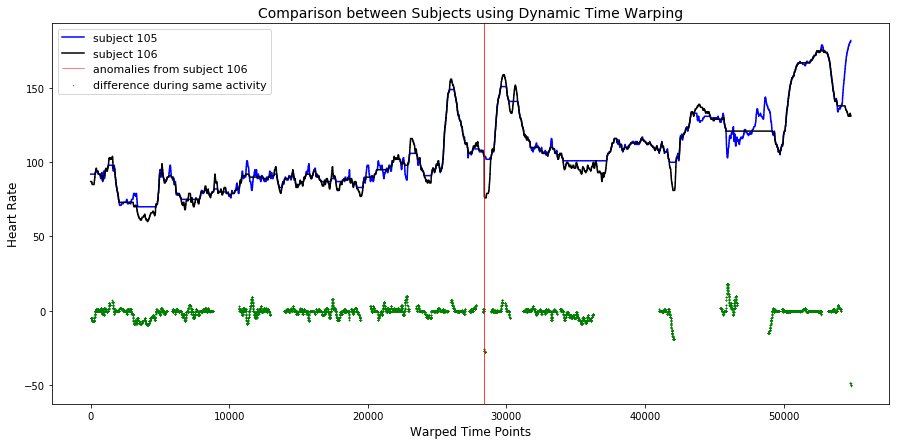

In [11]:
#plotting 
fig1 = plt.figure()
plt.plot(HR_105_dtw,'b', label='subject 105')
plt.plot(HR_106_dtw,'k', label='subject 106')

x=time_points_dtw[act_diff==0]
y=HR_diff[act_diff==0]
plt.scatter(x,y, color='g',marker='.', s=0.5,label='difference during same activity')

#overlay anomalies detected for subject 106
error_106 = pd.DataFrame(rec_106-HR_106[0:len(rec_106)])
anomaly_idx_106 = error_106[anomaly_106].index.values
min_idx = np.where(index2==min(anomaly_idx_106))
max_idx = np.where(index2==max(anomaly_idx_106))
plt.axvline(x=min_idx, color='r',lw=0.5)
plt.axvline(x=max_idx, color='r',lw=0.5, label='anomalies from subject 106')

plt.xlabel('Warped Time Points', fontsize=12)
plt.ylabel('Heart Rate',fontsize=12)
plt.title('Comparison between Subjects using Dynamic Time Warping', fontsize=14)
fig1.set_figwidth(15)
fig1.set_figheight(7)
plt.legend(fontsize=11)
plt.show()